在悬崖漫步环境中实现 Dyna-Q

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,起点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [8]:
# 然后我们在 Q-learning 的代码上进行简单修改，实现 Dyna-Q 的主要代码。最主要的修改是加入了环境模型model，用一个字典表示，每次在真实环境中收集到新的数据，就把它加入字典。
# 根据字典的性质，若该数据本身存在于字典中，便不会再一次进行添加。在 Dyna-Q 的更新中，执行完 Q-learning 后，会立即执行 Q-planning。

class DynaQ:
    """ Dyna-Q算法 """
    def __init__(self,
                 ncol,
                 nrow,
                 epsilon,
                 alpha,
                 gamma,
                 n_planning,
                 n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

        self.n_planning = n_planning  #执行Q-planning的次数, 对应1次Q-learning
        self.model = dict()  # 环境模型

    def take_action(self, state):  # 选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def q_learning(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max(
        ) - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

    def update(self, s0, a0, r, s1):
        self.q_learning(s0, a0, r, s1)
        self.model[(s0, a0)] = r, s1  # 将数据添加到模型中
        for _ in range(self.n_planning):  # Q-planning循环
            # 随机选择曾经遇到过的状态动作对
            (s, a), (r, s_) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r, s_)

In [9]:
# 下面是 Dyna-Q 算法在悬崖漫步环境中的训练函数，它的输入参数是 Q-planning 的步数。

def DynaQ_CliffWalking(n_planning):
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
    num_episodes = 300  # 智能体在环境中运行多少条序列

    return_list = []  # 记录每一条序列的回报
    for i in range(10):  # 显示10个进度条
        # tqdm的进度条功能
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                    agent.update(state, action, reward, next_state)
                    state = next_state
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 5882.34it/s, episode=300, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 3359.03it/s, episode=300, return=-13.500]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 707.48it/s, episode=300, return=-13.400]


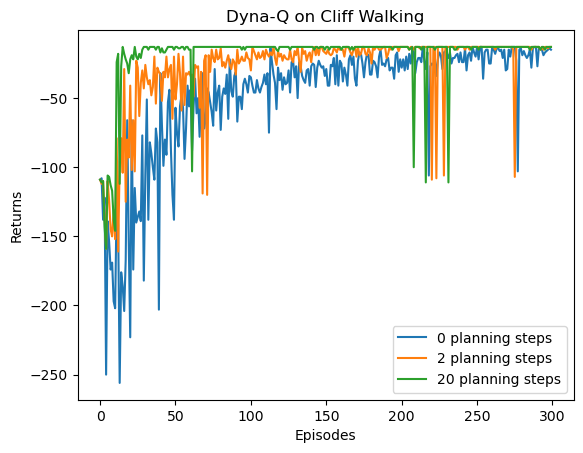

In [10]:
# 接下来对结果进行可视化，通过调整参数，我们可以观察 Q-planning 步数对结果的影响。若 Q-planning 步数为 0，Dyna-Q 算法则退化为 Q-learning

np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
for n_planning in n_planning_list:
    print('Q-planning步数为：%d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()